In [10]:
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings
import os
from langchain_community.document_loaders import GithubFileLoader




In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
loader = GithubFileLoader(
    repo="langchain-ai/open-canvas",
    access_token=os.environ["GITHUB_API_URL"],  # delete/comment out this argument if you've set the access token as an env var.
    branch="master",  # the branch name
    github_api_url="https://api.github.com",
    file_filter=lambda file_path: file_path.endswith(
    
     
   
        ".md"
    ),
)
docs = loader.load()

In [ ]:

access_token = os.environ["GITHUB_ACCESS_TOKEN"]
def read_files(repo):
    githubloader = GithubFileLoader(
        repo=repo,
        access_token=access_token,
        branch="main",
        github_api_url="https://api.github.com",
        file_filter=lambda file_path: file_path.endswith(
      (".md", ".ts",'.tsx')  
    
     
   
    ),
        )
    documents = githubloader.load()
    return documents

doc = read_files("langchain-ai/open-canvas")
len(doc)



147

In [24]:
def chunk_data(docs,chunk_size=1000, chunk_overlap=130):
   text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
   docs = text_splitter.split_documents(docs)
   return docs

documents = chunk_data(docs=doc)
len(documents)

728

In [21]:
print(doc[4])

page_content='import {
  OpenCanvasGraphAnnotation,
  OpenCanvasGraphReturnType,
} from "../../state";
import { LangGraphRunnableConfig } from "@langchain/langgraph";
import {
  getFormattedReflections,
  getModelFromConfig,
  getModelConfig,
  optionallyGetSystemPromptFromConfig,
} from "@/agent/utils";
import { ARTIFACT_TOOL_SCHEMA } from "./schemas";
import { ArtifactV3 } from "@/types";
import { createArtifactContent, formatNewArtifactPrompt } from "./utils";

/**
 * Generate a new artifact based on the user's query.
 */
export const generateArtifact = async (
  state: typeof OpenCanvasGraphAnnotation.State,
  config: LangGraphRunnableConfig
): Promise<OpenCanvasGraphReturnType> => {
  const { modelName } = getModelConfig(config);
  const smallModel = await getModelFromConfig(config, {
    temperature: 0.5,
  });

  const modelWithArtifactTool = smallModel.bindTools(
    [
      {
        name: "generate_artifact",
        schema: ARTIFACT_TOOL_SCHEMA,
      },
    ],
    { tool_ch

In [22]:
embeddings = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")

C:\Users\Dell\AppData\Local\Temp\ipykernel_16136\4023655766.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")


In [25]:
#This will create a new index in Pinecone
from pinecone import Pinecone, ServerlessSpec
import time

pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)

index_name = "open-canvas-assistant"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=spec
    )
    # Wait for index to be ready
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)


In [26]:
#This will upsert the documents into the index
from langchain.vectorstores import Pinecone
index = Pinecone.from_documents( documents, embeddings,index_name=index_name)

In [27]:
def retrieve_query(query,k=4):
    matching_results = index.similarity_search(query, k=k)
    return matching_results

In [29]:
from langchain.chains.question_answering import load_qa_chain
from langchain_groq import ChatGroq


groq_api_key = os.environ['GROQ_API_KEY']
llm = ChatGroq(
            groq_api_key=groq_api_key,
            model_name="mixtral-8x7b-32768",
            temperature=0.5,
    )
chain = load_qa_chain(llm,chain_type="stuff")

In [30]:
def chatbot(query):
    matching_results = retrieve_query(query)
    response = chain.run(input_documents=matching_results,question=query)
    return response

In [34]:
query = "I want to learn open canvas tell me first how to create nodes in open canvas. write code for it also add nodes and eges and build a graph"
answer = chatbot(query)
print(answer)

To create nodes in OpenCanvas, you can use the LangGraph Studio or the LangSmith platform as mentioned in the development section. After setting up the environment, you can create nodes by writing code using the GraphComponent and Node classes provided by the LangGraph library. Here is an example:

```jsx
import { GraphComponent, Node } from "langgraph";

// Create a new GraphComponent
const graphComponent = new GraphComponent();

// Create a new node
const node = new Node("My Node");

// Add the node to the graph
graphComponent.addNode(node);
```

To add edges between nodes, you can use the addEdge method provided by the GraphComponent class. Here is an example:

```jsx
import { GraphComponent, Node } from "langgraph";

// Create a new GraphComponent
const graphComponent = new GraphComponent();

// Create two nodes
const node1 = new Node("Node 1");
const node2 = new Node("Node 2");

// Add the nodes to the graph
graphComponent.addNode(node1);
graphComponent.addNode(node2);

// Add an 

In [35]:
retriever = index.as_retriever(search_type="similarity", search_kwargs={"k": 2})
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
        retriever,
        "retrieve_files_from_repository",
        "Search and return information about open-cnavas,nodes,edges,graph,canvas,agents, and all data from the document",
    )

tools = [retriever_tool]

In [36]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [37]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
  

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    
    response = llm.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\app-HIjgm-I8-py3.12\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [38]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

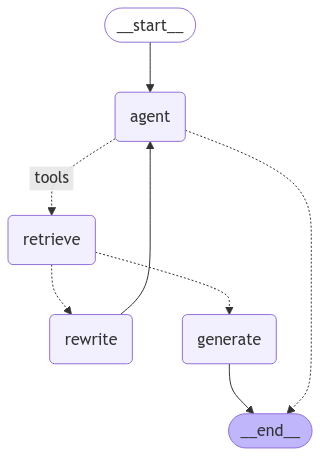

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
import pprint

inputs = {
    "messages": [
        ("user", "I want to learn open canvas tell me first how to create nodes in open canvas. write code for it also add nodes and eges and build a graph?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fjt0', 'function': {'arguments': '{"query":"tutorial for creating nodes in open canvas"}', 'name': 'retrieve_files_from_repository'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 425, 'prompt_tokens': 1235, 'total_tokens': 1660, 'completion_time': 0.681187227, 'prompt_time': 0.088373251, 'queue_time': 0.0009555680000000039, 'total_time': 0.769560478}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-187ccae3-af5f-45e7-bf24-de64ac80eec4-0', tool_calls=[{'name': 'retrieve_files_from_repository', 'args': {'query': 'tutorial for creating nodes in open canvas'}, 'id': 'call_fjt0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1235, 'output_tokens': 425, 'total_tokens': 1660})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEV

c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\app-HIjgm-I8-py3.12\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'To create nodes in OpenCanvas, you can use the deployed '
                'version at '
                '[opencanvas.langchain.com](https://opencanvas.langchain.com/) '
                'or clone the repository and run it locally. After setting up '
                'the environment, you can create nodes by adding content in '
                'the text or code editor. \n'
                '\n'
                'For adding nodes and edges programmatically, you can use '
                'LangGraphJS, a library for building and running Langchain '
                "graphs. Here's a sample code snippet:\n"
                '\n'
                '```javascript\n'
                'import { LangchainGraph, TextNode, Edge } from '
                "'langgraphjs';\n"
                '\n'
                'const graph = new LangchainGraph();\n'
                "const node1 = new TextNode('Hello');\n"
                "const node2 = new TextNode('World'